I compared n-step error vs TD error within the RandomWalk environment from Example 7.1.

I didn't arrive at a convincing enough conclusion, except that using the n-step error seems to be more stable than the sum of TD errors in that the RMS error is less susceptible to blowing up when the learning rate is large. When the learning rate is small, the performances are similar across all hyperparameters.

This makes me question the validity of my method. I may revisit this problem later and further investigate why the results are not satisfying.


In [172]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import math

In [173]:
class RandomWalkEnv(gym.Env):
    """
    Initializes a series of `size` states *including* the two terminal states.
    There are no actions.
    Args:
        size (int): The size of the random walk environment.
    """

    def __init__(self, size):
        super().__init__()

        self.n_states = size

        self.observation_space = spaces.Discrete(size)
        self.action_space = spaces.Discrete(1)

    def reset(self):
        self.state = self.n_states // 2
        return self.state, {}

    def step(self, action):
        s = self.state
        s += 1 if np.random.rand() < 0.5 else -1
        terminated = s == 0 or s == self.n_states - 1
        reward = -1 if s == 0 else 1 if s == self.n_states - 1 else 0
        self.state = s
        return s, reward, terminated, False, {}

In [225]:
np.empty(3)[0]
np.array([1, 2]) + np.array([1, 2])

array([2, 4])

In [327]:
# n-step TD using the n-step error (n real rewards plus bootstrapping)
def with_n_step_error(env: gym.Env, episodes, record_err_per, n, alpha, gamma):
    # value estimations (running)
    vs = np.zeros(env.n_states)
    # root mean squared errors
    rmse = np.empty(episodes // record_err_per)

    for ep in range(episodes):
        # previous n states
        ss = deque()
        # previous n rewards
        rs = deque()

        s, _ = env.reset()
        ss.append(s)

        done = False
        while not done:
            s, r, done, _, _ = env.step(None)
            rs.append(r)

            # n rewards accumulated, update the state n steps ago
            if len(rs) == n:
                s_old = ss.popleft()
                g = 0
                gamma_pow = 1
                for r in rs:
                    g += gamma_pow * r
                    gamma_pow *= gamma
                g += gamma_pow * vs[s]
                vs[s_old] += alpha * (g - vs[s_old])
                rs.popleft()

            ss.append(s)

        # episode ended, but the last n rewards are pending
        while len(rs) > 0:
            s_old = ss.popleft()
            g = 0
            gamma_pow = 1
            for r in rs:
                g += gamma_pow * r
                gamma_pow *= gamma
            vs[s_old] += alpha * (g - vs[s_old])
            rs.popleft()

        if ep % record_err_per == 0:
            index = ep // record_err_per
            error = 0
            for i in range(1, env.n_states - 1):
                v_star = 2 * i / (env.n_states - 1) - 1
                # print(f"for state {i}, {v_star=}")
                error += (vs[i] - v_star) ** 2
            error /= env.n_states - 2
            error = math.sqrt(error)
            rmse[index] = error

    return vs, rmse

In [328]:
# n-step TD by summing TD errors (n one-step errors)
def with_td_error(env: gym.Env, episodes, record_err_per, n, alpha, gamma):
    # value estimations (running)
    vs = np.zeros(env.n_states)
    # root mean squared errors
    rmse = np.empty(episodes // record_err_per)

    for ep in range(episodes):
        # previous n states
        ss = deque()
        # previous n TD errors
        deltas = deque()

        s, _ = env.reset()
        ss.append(s)

        done = False
        while not done:
            s, r, done, _, _ = env.step(None)
            delta = r + gamma * vs[s] - vs[ss[-1]]
            deltas.append(delta)

            # n deltas accumulated, update the state n steps ago
            if len(deltas) == n:
                s_old = ss.popleft()
                sum = 0
                gamma_pow = 1
                for delta in deltas:
                    sum += gamma_pow * delta
                    gamma_pow *= gamma
                vs[s_old] += alpha * sum
                deltas.popleft()

            ss.append(s)

        # episode ended, but the last n rewards are pending
        while len(deltas) > 0:
            s_old = ss.popleft()
            sum = 0
            gamma_pow = 1
            for delta in deltas:
                sum += gamma_pow * delta
                gamma_pow *= gamma
            vs[s_old] += alpha * sum
            deltas.popleft()

        if ep % record_err_per == 0:
            index = ep // record_err_per
            error = 0
            for i in range(1, env.n_states - 1):
                v_star = 2 * i / (env.n_states - 1) - 1
                error += (vs[i] - v_star) ** 2
            error /= env.n_states - 2
            error = math.sqrt(error)
            rmse[index] = error

    return vs, rmse

In [387]:
def graph_values(env, vs):
    fig, ax = plt.subplots()

    ax.plot([0, env.n_states - 1], [-1, 1], color="gray", linewidth=1)

    X = np.arange(1, env.n_states - 1)
    Y = vs[1:-1]
    ax.plot(X, Y, marker="o", linewidth=3)
    ax.set_title("Learned value function of RandomWalk")
    ax.set_xlabel(
        f"States ({env.n_states//2} is initial state, 0 and {env.n_states-1} are terminal)"
    )
    ax.set_xticks(X)
    ax.set_ylabel("Values (gray line shows true value)")

    plt.show()

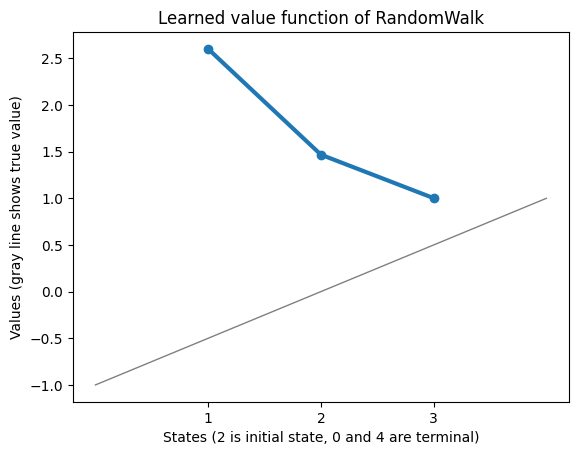

In [406]:
env = RandomWalkEnv(5)
vs, rmse = with_td_error(env, episodes=20, record_err_per=5, n=8, alpha=0.9, gamma=1)
graph_values(env, vs)

In [380]:
# Evaluate n-step error vs sum of TD errors.
def evaluate(env, episodes, record_err_per, runs=10, n=1, alpha=0.1, gamma=1.0):
    # vs_total = np.zeros(env.n_states)
    rmse_N_total = 0
    rmse_T_total = 0
    for run in range(runs):
        _, rmse = with_n_step_error(env, episodes, record_err_per, n, alpha, gamma)
        rmse_N_total += np.mean(rmse)

        _, rmse = with_td_error(env, episodes, record_err_per, n, alpha, gamma)
        rmse_T_total += np.mean(rmse)

    rmse_N_avg = rmse_N_total / runs
    rmse_T_avg = rmse_T_total / runs

    return rmse_N_avg, rmse_T_avg

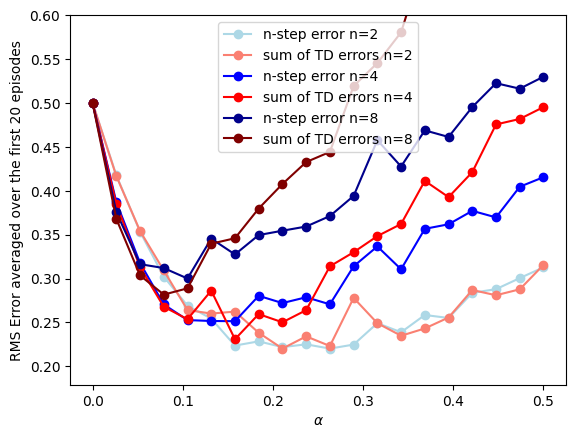

In [433]:
env = RandomWalkEnv(9)
episodes = 20
record_err_per = 2

alphas = np.linspace(0, 0.5, 20)


def plot_n(n, ax, color_N, color_T):
    global alphas
    err_N, err_T = np.empty(len(alphas)), np.empty(len(alphas))
    for index, alpha in enumerate(alphas):
        rmse_N_avg, rmse_T_avg = evaluate(
            env, episodes, record_err_per, n=n, alpha=alpha
        )
        err_N[index] = rmse_N_avg
        err_T[index] = rmse_T_avg
        # print(f"set err_T[{index}] <- {rmse_T_avg}")

    # print(f"for n=8", err_T)
    ax.plot(alphas, err_N, label=f"n-step error {n=}", color=color_N, marker="o")
    ax.plot(alphas, err_T, label=f"sum of TD errors {n=}", color=color_T, marker="o")


fig, ax = plt.subplots()
plot_n(2, ax, "lightblue", "salmon")
plot_n(4, ax, "blue", "red")
plot_n(8, ax, "darkblue", "maroon")

ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(f"RMS Error averaged over the first {episodes} episodes")
ax.set_ylim(None, 0.6)
ax.legend()
plt.show()

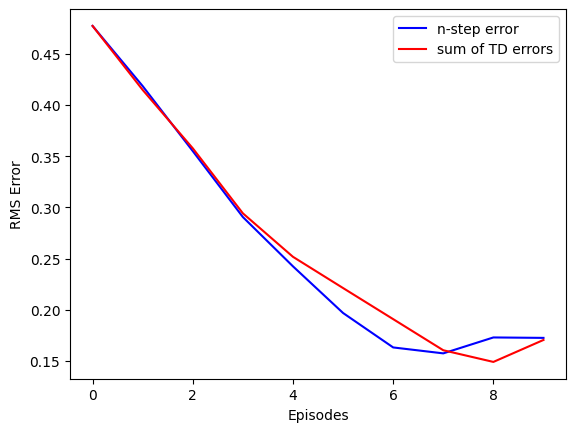

In [324]:
fig, ax = plt.subplots()

X = np.arange(0, episodes, record_err_per)
N = rmse_n_step_avg
T = rmse_td_avg

ax.plot(X, N, label="n-step error", color="blue")
ax.plot(X, T, label="sum of TD errors", color="red")
ax.legend()
ax.set_xlabel("Episodes")
ax.set_ylabel("RMS Error")

plt.show()